In [3]:
import os
import random
import cv2
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import tensorflow
from tensorflow.python.client import device_lib

In [4]:
torch.cuda.is_available()

False

In [5]:
def seed_everything(seed: int = 22):
       random.seed(seed)
       np.random.seed(seed)
       # torch.cuda.manual_seed(seed)
       # torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
tot_actions = 6
actions_name = ['ankle', 'fall', 'jump', 'knee', 'run', 'walk']
min_data_len = 35

In [7]:
actions_csv_dir = 'C:\\Users\\USER\Documents\GitHub\Basketball-injury-classification\AI창의융합경진대회\csv_dataset'
dataset = []

label_mapping = {'ankle': 0,
                 'fall': 1,
                 'jump': 2,
                 'knee': 3,
                 'run' : 4,
                 'walk' : 5
                 }

def map_action_to_label(csv_name):
       for action, label in label_mapping.items():
              if action in csv_name.split('_')[0]:
                     return label
       return -1

for action_csv in os.listdir(actions_csv_dir):
       action_df = pd.read_csv(os.path.join(actions_csv_dir, action_csv))
       label = map_action_to_label(action_csv)
       if label != -1:
              for idx in range(0, len(action_df), int(min_data_len / 2)):
                     seq_df = action_df[idx: idx + min_data_len] #길이만큼 데이터 자른 것(즉 length 만큼의 프레임)
                     if len(seq_df) == min_data_len: # 딱 length에 개수 맞춰서 끊어서 넣으려고
                            dataset.append({'key': label, 'value': seq_df}) # key에 slide, value에는 묶음 프레임 만큼이 담기겠네
       #최종적으로 dataset에는 행동별로 dictionary 가 만들어져 들어간다.

In [8]:
print(dataset[0]['value']) # z축 까지 99 (33 * 3)차원

      Nose_x    Nose_y    Nose_z  LEye_in_x  LEye_in_y  LEye_in_z    LEye_x  \
0   0.474492  0.332046 -0.597520   0.489540   0.321691  -0.571477  0.498821   
1   0.475332  0.332009 -0.602557   0.490261   0.321646  -0.576985  0.499209   
2   0.476175  0.331931 -0.607750   0.491060   0.321550  -0.582352  0.499774   
3   0.476764  0.331871 -0.626036   0.491667   0.321356  -0.600991  0.500314   
4   0.477602  0.331915 -0.642517   0.492951   0.321351  -0.618014  0.501654   
5   0.478491  0.331982 -0.663071   0.494410   0.321382  -0.637403  0.503239   
6   0.480438  0.332171 -0.671767   0.496188   0.321463  -0.645974  0.504998   
7   0.483270  0.332909 -0.675325   0.498812   0.322056  -0.648876  0.507751   
8   0.484854  0.333582 -0.670713   0.500705   0.322824  -0.644379  0.509833   
9   0.486051  0.334768 -0.666026   0.501942   0.324210  -0.639405  0.511123   
10  0.486912  0.335569 -0.661995   0.502973   0.325242  -0.635611  0.512315   
11  0.486973  0.336190 -0.664525   0.503309   0.3260

In [9]:
class MyDataset(Dataset):
       def __init__(self, dataset): #모든 행동을 통합한 df가 들어가야함
              self.x = []
              self.y = []
              for dic in dataset:
                     self.y.append(dic['key']) #key 값에는 actions 들어감
                     self.x.append(dic['value']) #action마다의 data 들어감

       def __getitem__(self, index): #index는 행동의 index
              data = self.x[index] # x에는 꺼내 쓸 (행동마다 45개 묶음프레임)의 데이터
              label = self.y[index]
              return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

       def __len__(self):
              return len(self.x)


In [11]:
train_test_val_ratio = [0.8, 0.1, 0.1]
print(len(dataset))
train_len = int(len(dataset) * train_test_val_ratio[0])
val_len = int(len(dataset) * train_test_val_ratio[1])
test_len = len(dataset) - train_len - val_len
print('{}, {}, {}'.format(train_len, val_len, test_len))

140
112, 14, 14


In [12]:
CFG = {'batch_size': 8,
       'learning_rate': 2e-2,
       'seed': 22,
       'epochs': 20     
}

In [13]:
train_dataset = MyDataset(dataset)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=CFG['batch_size'])
val_loader = DataLoader(valid_data, batch_size=CFG['batch_size'])
test_loader = DataLoader(test_data, batch_size=CFG['batch_size'])

In [14]:
from sklearn.utils import shuffle

def shuffle_dataset(lm_list, label_list):
       lm_list, label_list = shuffle(lm_list, label_list, random_state=22)
       return lm_list, label_list

In [15]:
class Model(nn.Module):
       def __init__(self):
              super(Model, self).__init__()
              self.hidden_size=128
              self.lstm = nn.LSTM(input_size=99, hidden_size=128, batch_first=True)
              self.fc = nn.Linear(128, 6)
              # self.lstm1 = nn.LSTM(input_size=99, hidden_size=128, num_layers=1, batch_first=True) 
              # self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, batch_first=True)
              # self.lstm3 = nn.LSTM(input_size=256, hidden_size=512, num_layers=1, batch_first=True)
              # self.dropout1 = nn.Dropout(0, 1)
              # self.lstm4 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)
              # self.lstm5 = nn.LSTM(input_size=256, hidden_size=128, num_layers=1, batch_first=True)
              # self.lstm6 = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
              # self.dropout2 = nn.Dropout(0, 1)
              # self.lstm7 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
              # self.fc = nn.Linear(32, 5) #분류할 클래스 5가지

       def forward(self, x):
              h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
              c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
              out, _ = self.lstm(0, (h0, c0))
              out = self.fc(out[:,-1, -1])
              out = nn.functional.softmax(out, dim=1)
              # x, _ = self.lstm1(x)
              # x, _ = self.lstm2(x)
              # x, _ = self.lstm3(x)
              # x = self.dropout1(x)
              # x, _ = self.lstm4(x)
              # x, _ = self.lstm5(x)
              # x, _ = self.lstm6(x)
              # x = self.dropout2(x)
              # x, _ = self.lstm7(x)
              # x = self.fc(x[:, -1, :])
              return x

In [16]:
class Model(nn.Module):
       def __init__(self):
              super(Model, self).__init__()
              self.recurrent_layer = nn.LSTM(hidden_size=100, input_size=99,  bidirectional=True)

              self.nonLin = nn.BatchNorm1d(35)
              self.recurrent_layer2 = nn.LSTM(hidden_size=100, input_size=200, bidirectional=True)
              self.nonLin2 = nn.BatchNorm1d(35)
              self.conv = nn.Conv1d(35,36,7,1)
              self.relu1 = nn.Softmax()
              self.classify_layer = nn.Linear(194, 6)

       # the size of input is [batch_size, seq_len(15), input_dim(75)]
       # the size of logits is [batch_size, num_class]
       def forward(self, input, h_t_1=None, c_t_1=None):
              # the size of rnn_outputs is [batch_size, seq_len, rnn_size]
              rnn_outputs, (hn, cn) = self.recurrent_layer(input)
              lin1 = self.nonLin(rnn_outputs)

              rnn_outputs2, (hn2, cn2) = self.recurrent_layer2(lin1)

              lin2 = self.nonLin2(rnn_outputs2)
              conv = self.conv(lin2)
              relu = self.relu1(conv)

              logits = self.classify_layer(relu[:,-1])
              return logits


In [20]:
from torchviz import make_dot
import torch
model = Model()
make_dot((1, 2, 3), params=dict(model.named_parameters()))



AttributeError: 'int' object has no attribute 'size'

In [17]:
# for data, label in test_loader:
#        print('data:', len(data)) # 배치만큼 출력하니까 'data: .  8.. '
d = []
l = []
for data, label in test_loader:
       d.append(data)
       l.append(label)
print(d[0].shape) # 8개 잡은 배치, 45개 seqence 길이, 99 차원

torch.Size([8, 35, 99])


C:\Users\USER\anaconda3\envs\py39\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 - valid Loss: 1.970374 - valid_acc : 0.145833
Epoch: 1 - valid Loss: 1.427352 - valid_acc : 0.562500
Epoch: 2 - valid Loss: 1.364425 - valid_acc : 0.312500
Epoch: 3 - valid Loss: 1.364069 - valid_acc : 0.520833
Epoch: 4 - valid Loss: 1.354587 - valid_acc : 0.583333
Epoch: 5 - valid Loss: 1.318299 - valid_acc : 0.645833
model save, model val acc :  0.6458333432674408
Epoch: 6 - valid Loss: 1.297680 - valid_acc : 0.583333
Epoch: 7 - valid Loss: 1.253034 - valid_acc : 0.562500
Epoch: 8 - valid Loss: 1.292185 - valid_acc : 0.750000
model save, model val acc :  0.75
Epoch: 9 - valid Loss: 1.281536 - valid_acc : 0.666667
Epoch: 10 - valid Loss: 1.215341 - valid_acc : 0.687500
Epoch: 11 - valid Loss: 1.302242 - valid_acc : 0.583333
Epoch: 12 - valid Loss: 1.241847 - valid_acc : 0.520833
Epoch: 13 - valid Loss: 1.378567 - valid_acc : 0.666667
Epoch: 14 - valid Loss: 1.216605 - valid_acc : 0.604167
Epoch: 15 - valid Loss: 1.279258 - valid_acc : 0.458333
Epoch: 16 - valid Loss: 1.314308

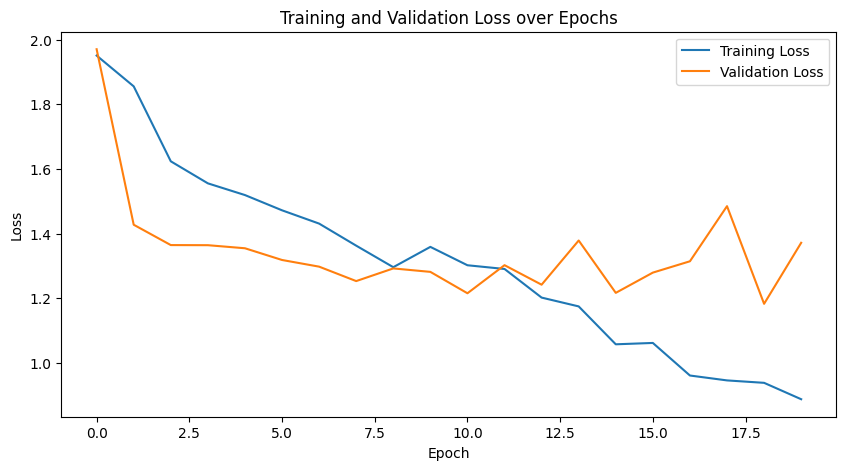

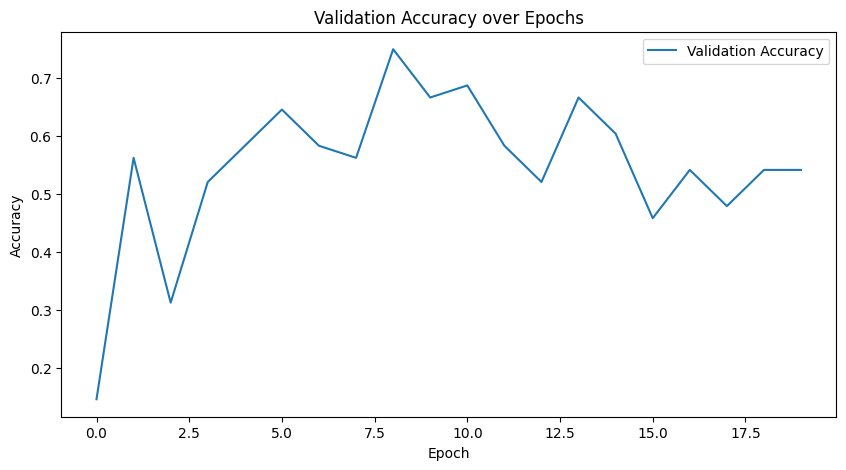

In [22]:
num_epochs = CFG['epochs']
best_models = []  # 폴드별로 가장 validation acc가 높은 모델 저장

model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['learning_rate'])
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.9)  # learning rate scheduler 로 학습률 주기적 감소

val_acc_max = 0.6
val_loss_min = 0.3

# Lists to store training and validation metrics for each epoch
train_loss_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
       train_loss_list = []
       val_loss_list = []
       val_acc_list = []

       # 모델 학습
       for i, (images, targets) in enumerate(train_loader):
              model.train()

              optimizer.zero_grad()
              outputs = model(images)

              targets = targets.long()
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()

              train_loss_list.append(loss.item())

              if (i + 1) % 20 == 0:
                     print(f'Epoch: {epoch} - Loss: {loss:.6f}')

       train_loss = np.mean(train_loss_list)

       # 모델 검증
       for i, (images, targets) in enumerate(val_loader):
              model.eval()

              with torch.no_grad():
                     outputs = model(images)

                     targets = targets.long()

                     val_loss = criterion(outputs, targets)

                     preds = torch.argmax(outputs, dim=1)

                     batch_acc = (preds == targets).float().mean()  # boolean 값의 평균

                     val_loss_list.append(val_loss.item())
                     val_acc_list.append(batch_acc.item())

       val_loss = np.mean(val_loss_list)
       val_acc = np.mean(val_acc_list)

       # Append metrics to the history lists
       train_loss_history.append(train_loss)
       val_loss_history.append(val_loss)
       val_acc_history.append(val_acc)

       print(f'Epoch: {epoch} - valid Loss: {val_loss:.6f} - valid_acc : {val_acc:.6f}')

       # val에서의 정확도 기준 모델 저장
       if val_acc_max < val_acc:
              val_acc_max = val_acc
              best_models.append(model)
              print('model save, model val acc : ', val_acc)

       # if val_loss_min > val_loss:
       #        val_loss_min = val_loss

       lr_scheduler.step()

print('Train finished, best_models size : ', len(best_models))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [30]:
save_directory = 'C:\\Users\\USER\Documents\GitHub\Basketball-injury-classification\AI창의융합경진대회\\saved_models\\'


for i, model in enumerate(best_models):
       model_filename = f"best_model_{i}.pth"
       model_path = save_directory + model_filename
       torch.save(model.state_dict(), model_path)
       print('asdf')

print(f"Saved {len(best_models)} models to {save_directory}")


asdf
asdf
Saved 2 models to C:\Users\USER\Documents\GitHub\Basketball-injury-classification\AI창의융합경진대회\saved_models\


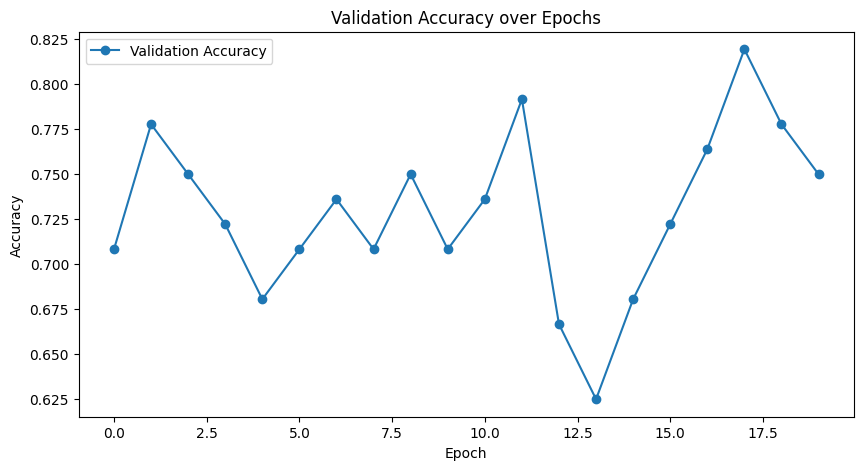

In [25]:
import matplotlib.pyplot as plt

# Validation accuracy values
val_acc_values = [0.708333, 0.777778, 0.75, 0.722222, 0.680556, 0.708333,
                  0.736111, 0.708333, 0.75, 0.708333, 0.736111, 0.791667,
                  0.666667, 0.625, 0.680556, 0.722222, 0.763889, 0.819444,
                  0.777778, 0.75]

# Plotting the validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(val_acc_values, label='Validation Accuracy', marker='o')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# 정확도 검증
for m in best_models:
       with torch.no_grad():
              test_loss, test_acc = epoch(test_loader, mode='test')
              test_acc = round(test_acc, 4)
              test_loss = round(test_loss, 4)
              print('Test Acc.: {}'.format(test_acc))
              print('Test Loss: {}'.format(test_loss))


In [31]:
def load_model(model, filepath):
       model.load_state_dict(torch.load(filepath))
       model.eval()
       return model

load_directory = save_directory 


num_models = 8


test_accuracies = []

# Iterate through each model
for i in range(num_models):
       # Create a new instance of your model
       model = Model()

       # Load the model from the file
       model_filename = f"best_model_fold_{i}.pth"
       model_path = load_directory + model_filename
       model = load_model(model, model_path)

       # Test the model on the test set
       correct = 0
       total = 0
       with torch.no_grad():
              for images, targets in test_loader:
                     outputs = model(images)
                     _, predicted = torch.max(outputs.data, 1)
                     total += targets.size(0)
                     correct += (predicted == targets).sum().item()

       # Calculate the accuracy for this model
       accuracy = correct / total
       test_accuracies.append(accuracy)

       print(f"Model {i+1} - Test Accuracy: {accuracy:.4f}")

# Print the average test accuracy across all models
average_accuracy = sum(test_accuracies) / num_models
print(f"Average Test Accuracy: {average_accuracy:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\Documents\\GitHub\\Basketball-injury-classification\\AI창의융합경진대회\\saved_models\\best_model_fold_0.pth'

In [24]:
# 여기부터 실시간 영상 테스트

interval = 1
video_path = '../dataset/slide/slide001.mp4'

cap = cv2.VideoCapture(video_path)
img_list = []
if cap.isOpened():
       cnt = 0
       while True:
              ret, img = cap.read()
              if ret:
                     img = cv2.resize(img, (640, 640))
                     if cnt == interval:
                            img_list.append(img)
                            cnt = 0
                     cv2.imshow(video_path, img)
                     cv2.waitKey(1)
                     cnt += 1
              else:
                     break
cap.release()
cv2.destroyAllWindows()

print('저정된 frame의 개수: {}'.format(len(img_list)))

저정된 frame의 개수: 148


In [33]:
# 연속 시퀀스 분석
from tqdm import tqdm
model_filename = f"best_model_fold_1.pth"
model_path = load_directory + model_filename
model = load_model(model, model_path)

model.eval()
out_img_list = []
dataset = []
status = 'None'
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, min_detection_confidence=0.7, min_tracking_confidence=0.5)


print('시퀀스 데이터 분석 중...')
xy_list_list = []


for img in tqdm(img_list):
       results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
       if not results.pose_landmarks: continue
       xy_list = []
       idx = 0
       for x_and_y in results.pose_landmarks.landmark:
              xy_list.append(x_and_y.x)
              xy_list.append(x_and_y.y)
              x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
       idx += 1
       xy_list_list.append(xy_list)

       length = 45
       if len(xy_list_list) == length:
              dataset = []
              dataset.append({'key': 0, 'value': xy_list_list})
              dataset = MyDataset(dataset)
              dataset = DataLoader(dataset)
              xy_list_list = []
              for data, label in dataset:
                     with torch.no_grad():
                            result = model(data)
                            _, out = torch.max(result, 1)
                            print(out.item())
       cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
       out_img_list.append(img)
           
       
       
       
       


시퀀스 데이터 분석 중...


 28%|██▊       | 41/148 [00:01<00:03, 33.13it/s]C:\Users\USER\anaconda3\envs\py39\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 33%|███▎      | 49/148 [00:01<00:03, 32.12it/s]

2


 66%|██████▌   | 97/148 [00:03<00:01, 32.86it/s]

2


 95%|█████████▌| 141/148 [00:04<00:00, 32.68it/s]

2


100%|██████████| 148/148 [00:04<00:00, 32.44it/s]


In [29]:
xy_list_list

[]